In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## File Naming Convention

Each `.pt` file should follow this format:

```
<label>_<replicate>.pt
```

**Examples:**
- `150_1.pt` → Label: 150 (undetectable), Replicate: 1
- `500_2.pt` → Label: 500 (low), Replicate: 2
- `7000_3.pt` → Label: 7000 (medium), Replicate: 3
- `20000_5.pt` → Label: 20000 (high), Replicate: 5



## Class Definitions for Semi-Quantitative approach 

Infers clinical decision-making based on viral load counts (assuming 1:1 sample prep
)
1. `undetectable` → Label values `< 200`
2. `low` → Label values `200 ≤ label ≤ 1000`
3. `medium` → Label values `1000 < label ≤ 10000`
4. `high` → Label values `> 10000`

# Dataset Folder Structure

Dataset is organized into the following structure to ensure proper training, validation, and testing:

```
Datasets/
│-- SemiQuant/
│   │-- Training/             # Training dataset (60% of total data)
│   │   ├── undetectable/      # Class 0 (e.g., files with labels < 200)
│   │   │   ├── 20_1.pt
│   │   │   ├── 40_3.pt
│   │   │   └── ...
│   │   ├── low/               # Class 1 (200 ≤ label ≤ 1000)
|   |   |   ├── 300_2.pt
│   │   │   ├── 600_4.pt
│   │   │   └── ...
│   │   ├── medium/            # Class 2 (1000 < label ≤ 10000)
│   │   │   ├── 2000_1.pt
│   │   │   ├── 7000_2.pt
│   │   │   └── ...
│   │   ├── high/              # Class 3 (label > 10000)
│   │   │   ├── 10000_2.pt
│   │   │   ├── 90000_2.pt
│   │   │   └── ...
│
│   │-- Validation/            # Validation dataset (20% of total data)
│   │   ├── undetectable/
│   │   │   ├── 20_2.pt
│   │   │   ├── 40_4.pt
│   │   │   └── ...
│   │   ├── low/
│   │   ├── medium/
│   │   ├── high/
│
│   │-- Testing/               # Testing dataset (20% of total data)
│   │   ├── undetectable/
│   │   │   ├── 30_1.pt
│   │   │   ├── 50_2.pt
│   │   │   └── ...
│   │   ├── low/
│   │   ├── medium/
│   │   ├── high/
│
│-- torch_tensors/              # Original .pt files before splitting
│   │   ├── 100_1.pt
│   │   ├── 200_3.pt
│   │   ├── 5000_2.pt
│   │   ├── 15000_4.pt
│   │   └── ...
```

## Folder Descriptions

- **`Training/`** – Used to train the model (60% of total data).
- **`Validation/`** – Used to validate the model during training (20% of total data).
- **`Testing/`** – Used to evaluate the model after training (20% of total data).
- **`torch_tensors/`** – Stores the original `.pt` files before they were split.



In [2]:
class PTDataset(Dataset):
    def __init__(self, root_dir, target_size=(500, 500), transform=None):
        """
        Args:
            root_dir (str): Path to the dataset directory (e.g., Training folder).
            target_size (tuple): Desired output size (height, width).
            transform (callable, optional): Optional transformations (on CPU).
        """
        self.root_dir = root_dir
        self.target_size = target_size
        self.transform = transform
        self.classes = ['undetectable', 'low', 'medium', 'high']
        # self.classes = ['0.undetectable', '1.low', '2.medium', '3.high', '4.very high']


        # Collect all file paths and labels
        self.file_list = []
        for label in self.classes:
            class_path = os.path.join(root_dir, label)
            if not os.path.exists(class_path):
                continue  # Skip if folder doesn't exist
            for file in os.listdir(class_path):
                if file.endswith('.pt'):
                    full_path = os.path.join(class_path, file)
                    class_index = self.classes.index(label)
                    self.file_list.append((full_path, class_index))

        # Pre-load everything into memory (CPU)
        self.data_list = []
        for file_path, label in self.file_list:
            # Load from disk to CPU memory
            tensor_data = torch.load(file_path, map_location='cpu')  # [C, T, H, W]

            # Ensure enough frames
            max_frames = tensor_data.shape[1]
            # selected_frame_indices = [ 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179]
            selected_frame_indices = [69, 89, 109, 129, 149, 179]
            selected_frame_indices = [i for i in selected_frame_indices if i < max_frames]
            if len(selected_frame_indices) < 6:
                raise ValueError(f"Not enough frames in {file_path}, available: {max_frames}, required: 180")

            # Compute average of the first 20 frames
            avg_first_20 = torch.mean(tensor_data[:, :20, :, :], dim=1, keepdim=True)  # [C, 1, H, W]
            selected_frames = tensor_data[:, selected_frame_indices, :, :]             # [C, 6, H, W]

            # Concatenate to form a 7-frame tensor
            final_tensor = torch.cat((avg_first_20, selected_frames), dim=1)  # [C, 7, H, W]
            final_tensor = final_tensor.squeeze(0) if final_tensor.shape[0] == 1 else final_tensor

            # Resize on CPU
            if final_tensor.dim() == 3:
                # shape [7, H, W]
                final_tensor = final_tensor.unsqueeze(0)  # -> [1, 7, H, W]

            resized_tensor = F.interpolate(
                final_tensor,
                size=self.target_size,
                mode='bilinear',
                align_corners=False
            )

            # Optional transform
            if self.transform:
                resized_tensor = self.transform(resized_tensor)

            # Model expects input_channels=7, flatten [C=1, frames=7, H, W] -> [7, H, W]
            if resized_tensor.shape[0] == 1:
                resized_tensor = resized_tensor.squeeze(0)  # shape [7, H, W]

            # Store (tensor, label)
            self.data_list.append((resized_tensor, label))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

In [ ]:
def get_resnet_model(num_classes=4, input_channels=7, dropout_rate=0.243493213909431):
    """
    Build ResNet18 with a custom first conv layer
    that expects `input_channels` and adds a Dropout layer.

    model_depth = 18 (ResNet18)
    """
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    # Replace first conv to match your input_channels
    model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Replace FC layer to include Dropout before classification
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_rate),  # Dropout before final classification
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model


def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Use AMP if on GPU
            with torch.amp.autocast(device_type='cuda', enabled=(device.type == 'cuda')):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    avg_acc = 100.0 * correct / total
    return avg_loss, avg_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=25):
    """
    Basic training routine using CrossEntropyLoss
    for single-label, multi-class classification.
    """
    
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            
            with torch.amp.autocast(device_type='cuda', enabled=(device.type == 'cuda')):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total

        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    print("Training complete.")

def plot_confusion_matrix(model, loader, device, class_names):
    """
    Generates and displays a confusion matrix for the model on the given loader.
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    conf_matrix = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


train_dataset_path = 'H:/Datasets/int_split/Training/'
val_dataset_path   = 'H:/Datasets/int_split/Validation/'
test_dataset_path  = 'H:/Datasets/int_split/Testing/'

# train_dataset_path = 'H:/Datasets/Log_split/Training/'
# val_dataset_path   = 'H:/Datasets/Log_split/Validation/'
# test_dataset_path  = 'H:/Datasets/Log_split/Testing/'

def main():
    #Check device for CUDA or CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    
    train_dataset = PTDataset(root_dir=train_dataset_path, target_size=(500, 500))
    val_dataset   = PTDataset(root_dir=val_dataset_path,   target_size=(500, 500))
    test_dataset  = PTDataset(root_dir=test_dataset_path,  target_size=(500, 500))

   
    train_labels = [label for _, label in train_dataset.data_list]
    print("Labels in dataset:", set(train_labels))

    class_counts = Counter(train_labels)
    weights = [1.0 / class_counts[label] for label in train_labels]
    
    train_sampler = WeightedRandomSampler(
        weights=weights,
        num_samples=len(weights),
        replacement=True
    )

    
    use_pin_memory = (device.type == 'cuda')
    batch_size = 32 
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        shuffle=False,
        num_workers=0,
        pin_memory=use_pin_memory
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=use_pin_memory
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=use_pin_memory
    )

    
    best_val_acc = -float('inf')
    best_model_state = None

    # Train/Evaluate 5 times
    for run_idx in range(5):
        print(f"\n=== Training Run {run_idx+1} of 5 ===")

        
        model = get_resnet_model(num_classes=4, input_channels=7)  
        model.to(device)

        criterion = nn.CrossEntropyLoss()

        # learning_rate = 0.0038825206157311557
        # weight_decay  = 0.0001931053552153856
        # gamma_rate    = 0.9388047294838997

        learning_rate = 0.00408909107539898
        weight_decay  = 0.0000217293313972603
        gamma_rate    = 0.972442722810877
        
        optimizer = optim.SGD(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
            momentum=0.9
        )

        # optimizer = optim.Adam(
        #     model.parameters(),
        #     lr=learning_rate,
        #     weight_decay=weight_decay
        # )

        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma_rate)

        
        num_epochs = 18
        train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            num_epochs=num_epochs
        )

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        print(f"Run {run_idx+1} validation accuracy: {val_acc:.2f}%")

        # Keep track of best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            print(f"New best model found with val_acc={val_acc:.2f}% (Run {run_idx+1}).")

    # After all 5 runs, save only the best model
    if best_model_state is not None:
        torch.save(best_model_state, 'resnet_model_3
                   .pth')
        print(f"\nBest model saved with val_acc={best_val_acc:.2f}%")

        best_model = get_resnet_model(num_classes=4, input_channels=7)
        best_model.load_state_dict(best_model_state)
        best_model.to(device)

        test_loss, test_acc = evaluate_model(best_model, test_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}% for the best model")

if __name__ == "__main__":
    main()


Using device: cuda
Labels in dataset: {0, 1, 2, 3}

=== Training Run 1 of 5 ===
Epoch [1/18] Train Loss: 1.3560, Train Acc: 41.84%, Val Loss: 1.2972, Val Acc: 59.18%
Epoch [2/18] Train Loss: 0.8087, Train Acc: 70.21%, Val Loss: 0.7574, Val Acc: 73.47%
Epoch [3/18] Train Loss: 0.5634, Train Acc: 75.89%, Val Loss: 0.6552, Val Acc: 83.67%
Epoch [4/18] Train Loss: 0.2702, Train Acc: 89.36%, Val Loss: 0.5988, Val Acc: 85.71%
Epoch [5/18] Train Loss: 0.3153, Train Acc: 87.94%, Val Loss: 0.7486, Val Acc: 79.59%
Epoch [6/18] Train Loss: nan, Train Acc: 60.28%, Val Loss: nan, Val Acc: 16.33%
Epoch [7/18] Train Loss: 0.1849, Train Acc: 94.33%, Val Loss: nan, Val Acc: 16.33%
Epoch [8/18] Train Loss: 0.2362, Train Acc: 90.78%, Val Loss: nan, Val Acc: 16.33%
Epoch [9/18] Train Loss: 0.0870, Train Acc: 96.45%, Val Loss: nan, Val Acc: 16.33%
Epoch [10/18] Train Loss: nan, Train Acc: 78.01%, Val Loss: nan, Val Acc: 16.33%
Epoch [11/18] Train Loss: 0.1354, Train Acc: 95.74%, Val Loss: nan, Val Acc: 16.

<Figure size 800x600 with 0 Axes>

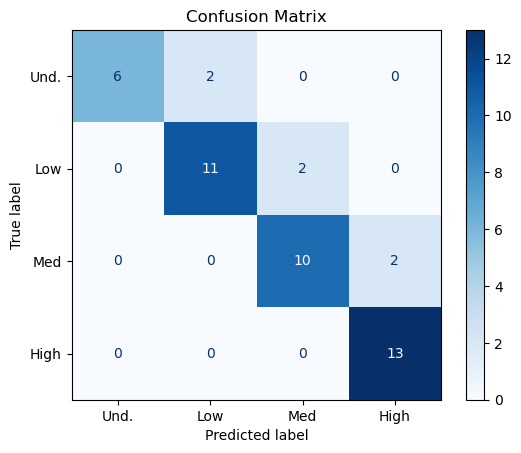

In [7]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def load_best_model(model_path, num_classes=4, input_channels=7, dropout_rate=0.243493213909431):
    """
    Load the best trained model from saved weights.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.conv1 = torch.nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout_rate),
        torch.nn.Linear(model.fc.in_features, num_classes)
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  

    return model, device

def plot_confusion_matrix(model, loader, device, class_names):
    """
    Generates and displays a confusion matrix for the model on the given loader.
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

model_path = "resnet_model_optuna.pth"
model, device = load_best_model(model_path)

test_dataset_path = 'H:/Datasets/int_split/Testing/'
test_dataset = PTDataset(root_dir=test_dataset_path, target_size=(500, 500))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=(device.type == 'cuda')
)

class_names = ['Und.', 'Low', 'Med', 'High']  

plot_confusion_matrix(model, test_loader, device, class_names)



# Hyperparameter sweep

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

def hyperparameter_search(output_dir, hyperparams, train_dataset, val_dataset, test_dataset):
    """
    Perform a grid search over the given hyperparameters.

    Args:
        output_dir (str): Directory to save results
        hyperparams (dict): Dictionary of hyperparameters to search
        train_dataset, val_dataset, test_dataset: Datasets for training, validation, and testing
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Get all hyperparameter combinations
    keys, values = zip(*hyperparams.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    for params in param_combinations:
        model_depth = params['model_depth']
        batch_size = params['batch_size']
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        dropout = params['dropout']
        gamma = params['gamma']
        gamma_rate = params['gamma_rate']
        num_epochs = params['num_epochs']
        optimizer_type = params['optimizer']
        
        # Weighted sampler for balancing dataset
        train_labels = [label for _, label in train_dataset.data_list]
        class_counts = Counter(train_labels)
        weights = [1.0 / class_counts[label] for label in train_labels]
        train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)
        
        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
        
        # Initialize model
        model = get_resnet_model(model_depth=model_depth, dropout=dropout).to(device)
        
        criterion = nn.CrossEntropyLoss()
        if optimizer_type == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        elif optimizer_type == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
        elif optimizer_type == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        else:
            raise ValueError("Unsupported optimizer type")
        
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma_rate) if gamma else None
        
        logs = []
        for epoch in range(num_epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
            train_loss = running_loss / total
            train_acc = 100.0 * correct / total
            val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
            if scheduler:
                scheduler.step()
            
            logs.append({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc
            })
        
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        
        # Save results
        result_dir = os.path.join(output_dir, f"model_{model_depth}_batch_{batch_size}_lr_{learning_rate}_wd_{weight_decay}_dropout_{dropout}_gamma_{gamma}_gammaRate_{gamma_rate}_epochs_{num_epochs}_opt_{optimizer_type}")
        os.makedirs(result_dir, exist_ok=True)
        
        torch.save(model.state_dict(), os.path.join(result_dir, "model_weights.pth"))
        with open(os.path.join(result_dir, "logs.json"), 'w') as f:
            json.dump(logs, f, indent=4)
        with open(os.path.join(result_dir, "params.json"), 'w') as f:
            json.dump(params, f, indent=4)
        
        print(f"Finished training: {params}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

hyperparams = {
    'model_depth': [18, 34],
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.0001],
    'weight_decay': [0.0001, 0.001],
    'dropout': [0.2, 0.5],
    'gamma': [True, False],
    'gamma_rate': [0.95, 0.99],
    'num_epochs': [10, 20],
    'optimizer': ['Adam', 'SGD', 'RMSprop']
}

output_directory = "./grid_search_results"

datasets = (train_dataset, val_dataset, test_dataset)

hyperparameter_search(output_directory, hyperparams, *datasets)


# Optuna

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from itertools import product
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np

# Load datasets
train_dataset_path = 'H:/Datasets/int_split/Training/'
val_dataset_path = 'H:/Datasets/int_split/Validation/'
test_dataset_path = 'H:/Datasets/int_split/Testing/'

train_dataset = PTDataset(root_dir=train_dataset_path, target_size=(500, 500))
val_dataset = PTDataset(root_dir=val_dataset_path, target_size=(500, 500))
test_dataset = PTDataset(root_dir=test_dataset_path, target_size=(500, 500))

def get_resnet_model(model_depth=34, dropout=0.5, num_classes=4, input_channels=7):
    """Returns a ResNet model with specified depth and dropout."""
    if model_depth == 18:
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_depth == 34:
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    elif model_depth == 50:
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    else:
        raise ValueError("Invalid ResNet depth. Choose from 18, 34, or 50.")
    
    model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify for 7 channels
    model.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

def evaluate_model(model, loader, criterion, device):
    """Evaluates the model on a dataset."""
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = 100.0 * correct / total
    return avg_loss, avg_acc

def objective(trial):
    """Optuna optimization function with multiple runs per trial."""
    params = {
        'model_depth': trial.suggest_categorical('model_depth', [18, 34]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
        'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-2),
        'dropout': trial.suggest_uniform('dropout', 0, 0.9),
        'gamma': trial.suggest_categorical('gamma', [True, False]),
        'gamma_rate': trial.suggest_uniform('gamma_rate', 0.9, 0.99),
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'ASGD', 'LBFGS'])
    }
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    val_accuracies = []

    # Run each trial 5 times
    for run in range(5):
        model = get_resnet_model(params['model_depth'], params['dropout']).to(device)
        criterion = nn.CrossEntropyLoss()
        
        if params['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
        elif params['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'], momentum=0.9)
        elif params['optimizer'] == 'ASGD':
            optimizer = optim.ASGD(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
        elif params['optimizer'] == 'LBFGS':
            optimizer = optim.LBFGS(model.parameters(), lr=params['learning_rate'])  # Removed weight_decay
        else:
            raise ValueError("Unsupported optimizer type")
        
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['gamma_rate']) if params['gamma'] else None
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        for epoch in range(25):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                def closure():
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    return loss
                
                if params['optimizer'] == 'LBFGS':
                    optimizer.step(closure)  # Requires closure function
                else:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
            
            if scheduler:
                scheduler.step()

        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        val_accuracies.append(val_acc)

    # Calculate statistics
    min_acc = np.min(val_accuracies)
    max_acc = np.max(val_accuracies)
    avg_acc = np.mean(val_accuracies)
    std_acc = np.std(val_accuracies)
    
    # Report all statistics
    trial.set_user_attr("min_accuracy", min_acc)
    trial.set_user_attr("max_accuracy", max_acc)
    trial.set_user_attr("avg_accuracy", avg_acc)
    trial.set_user_attr("std_accuracy", std_acc)
    
    # Print statistics for each trial
    print(f"\nTrial {trial.number} - Results:")
    print(f"  Parameters: {params}")
    print(f"  Min Accuracy: {min_acc:.2f}%")
    print(f"  Max Accuracy: {max_acc:.2f}%")
    print(f"  Avg Accuracy: {avg_acc:.2f}%")
    print(f"  Std Dev Accuracy: {std_acc:.2f}%\n")
    
    # Optuna will optimize for average accuracy
    return -avg_acc  # Minimizing negative accuracy to maximize positive accuracy

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Display results
best_trial = study.best_trial
print("\nBest trial:")
print(f"  Value: {-best_trial.value}")  # Converting back to positive accuracy
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Display additional statistics
print("\n  Additional statistics: ")
print(f"    Min Accuracy: {best_trial.user_attrs['min_accuracy']:.2f}%")

print(f"    Max Accuracy: {best_trial.user_attrs['max_accuracy']:.2f}%")
print(f"    Avg Accuracy: {best_trial.user_attrs['avg_accuracy']:.2f}%")
print(f"    Std Accuracy: {best_trial.user_attrs['std_accuracy']:.2f}%")


In [8]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np

# Load datasets
# train_dataset_path = 'H:/Datasets/int_split/Training/'
# val_dataset_path = 'H:/Datasets/int_split/Validation/'
# test_dataset_path = 'H:/Datasets/int_split/Testing/'

train_dataset_path = 'H:/Datasets/Log_split/Training/'
val_dataset_path   = 'H:/Datasets/Log_split/Validation/'
test_dataset_path  = 'H:/Datasets/Log_split/Testing/'

train_dataset = PTDataset(root_dir=train_dataset_path, target_size=(500, 500))
val_dataset = PTDataset(root_dir=val_dataset_path, target_size=(500, 500))
test_dataset = PTDataset(root_dir=test_dataset_path, target_size=(500, 500))

def get_resnet_model(model_depth=34, dropout=0.5, num_classes=5, input_channels=7):
    """Returns a ResNet model with specified depth and dropout."""
    if model_depth == 18:
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_depth == 34:
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    elif model_depth == 50:
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    else:
        raise ValueError("Invalid ResNet depth. Choose from 18, 34, or 50.")
    
    model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify for 7 channels
    model.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

def evaluate_model(model, loader, criterion, device):
    """Evaluates the model on a dataset."""
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = 100.0 * correct / total
    return avg_loss, avg_acc

def objective(trial):
    """Optuna optimization function with pruning."""
    params = {
        'model_depth': trial.suggest_categorical('model_depth', [18, 34]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
        'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-2),
        'dropout': trial.suggest_uniform('dropout', 0, 0.9),
        'gamma': trial.suggest_categorical('gamma', [True, False]),
        'gamma_rate': trial.suggest_uniform('gamma_rate', 0.9, 0.99),
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'ASGD', 'LBFGS'])
    }
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_resnet_model(params['model_depth'], params['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()
    
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'], momentum=0.9)
    elif params['optimizer'] == 'ASGD':
        optimizer = optim.ASGD(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'LBFGS':
        optimizer = optim.LBFGS(model.parameters(), lr=params['learning_rate'])  # Removed weight_decay
    else:
        raise ValueError("Unsupported optimizer type")
    
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['gamma_rate']) if params['gamma'] else None
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Training loop with pruning
    for epoch in range(25):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss
            
            if params['optimizer'] == 'LBFGS':
                optimizer.step(closure)
            else:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        if scheduler:
            scheduler.step()

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        # Report intermediate result for pruning
        trial.report(val_acc, epoch)

        # Stop early if performance is worse than previous trials at this step
        if trial.should_prune():
            raise optuna.TrialPruned()

    return -val_acc  # Minimizing negative accuracy to maximize positive accuracy

# Run Optuna study with Median Pruner
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))
study.optimize(objective, n_trials=200)

# Display results
best_trial = study.best_trial
print("\nBest trial:")
print(f"  Value: {best_trial.value}")  # Converting back to positive accuracy
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-02-26 13:23:30,587] A new study created in memory with name: no-name-2694195e-e012-4c12-983a-1ca102ad46e6
C:\Users\Colem\AppData\Local\Temp\ipykernel_24320\2031612572.py:63: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
C:\Users\Colem\AppData\Local\Temp\ipykernel_24320\2031612572.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-2),
C:\Users\Colem\AppData\Local\Temp\ipykernel_24320\2031612572.py:65: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/o


Best trial:
  Value: -85.71428571428571
  Params: 
    model_depth: 18
    learning_rate: 0.00010693471395379046
    weight_decay: 2.366898587557215e-06
    dropout: 0.4955157772921656
    gamma: True
    gamma_rate: 0.9401941147532752
    optimizer: Adam


In [8]:
import os
import torch
import torch.nn.functional as F

def process_and_save(root_dir, save_dir, target_size=(500, 500)):
    """
    Extracts the first 20 frames' average and 6 selected frames, resizes, and saves to new .pt files.
    """
    classes = ['undetectable', 'low', 'medium', 'high']
    selected_frame_indices = [69, 89, 109, 129, 149, 179]

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for label in classes:
        class_path = os.path.join(root_dir, label)
        save_class_path = os.path.join(save_dir, label)
        
        if not os.path.exists(class_path):
            continue  # Skip if folder doesn't exist
        
        if not os.path.exists(save_class_path):
            os.makedirs(save_class_path)
        
        for file in os.listdir(class_path):
            if file.endswith('.pt'):
                file_path = os.path.join(class_path, file)
                save_file_path = os.path.join(save_class_path, file)
                
                
                tensor_data = torch.load(file_path, map_location='cpu')  # [C, T, H, W]
                max_frames = tensor_data.shape[1]
                
                
                valid_frames = [i for i in selected_frame_indices if i < max_frames]
                if len(valid_frames) < 6:
                    print(f"Skipping {file_path}: Not enough frames ({max_frames} available, required 180)")
                    continue
                
                # Compute average of the first 20 frames
                avg_first_20 = torch.mean(tensor_data[:, :20, :, :], dim=1, keepdim=True)  # [C, 1, H, W]
                selected_frames = tensor_data[:, valid_frames, :, :]  # [C, 6, H, W]
                
                # Concatenate to form a 7-frame tensor
                final_tensor = torch.cat((avg_first_20, selected_frames), dim=1)  # [C, 7, H, W]
                final_tensor = final_tensor.squeeze(0) if final_tensor.shape[0] == 1 else final_tensor
                
              
                if final_tensor.dim() == 3:
                    final_tensor = final_tensor.unsqueeze(0)  # -> [1, 7, H, W]
                
                resized_tensor = F.interpolate(
                    final_tensor, size=target_size, mode='bilinear', align_corners=False
                )
                
            
                torch.save(resized_tensor, save_file_path)
                print(f"Saved: {save_file_path}")

# Example usage
train_dataset_path = 'H:/Datasets/int_split/Training/'
val_dataset_path = 'H:/Datasets/int_split/Validation/'
test_dataset_path = 'H:/Datasets/int_split/Testing/'

train_save_path = 'H:/Datasets/reduced/Training/'
val_save_path = 'H:/Datasets/reduced/Validation/'
test_save_path = 'H:/Datasets/reduced/Testing/'

process_and_save(train_dataset_path, train_save_path)
process_and_save(val_dataset_path, val_save_path)
process_and_save(test_dataset_path, test_save_path)

Saved: H:/Datasets/reduced/Training/undetectable\0_1.pt
Saved: H:/Datasets/reduced/Training/undetectable\0_2.pt
Saved: H:/Datasets/reduced/Training/undetectable\0_3.pt
Saved: H:/Datasets/reduced/Training/undetectable\0_4.pt
Saved: H:/Datasets/reduced/Training/undetectable\0_5.pt
Saved: H:/Datasets/reduced/Training/undetectable\0_6.pt
Saved: H:/Datasets/reduced/Training/undetectable\100_1.pt
Saved: H:/Datasets/reduced/Training/undetectable\100_6.pt
Saved: H:/Datasets/reduced/Training/undetectable\140_2.pt
Saved: H:/Datasets/reduced/Training/undetectable\20_3.pt
Saved: H:/Datasets/reduced/Training/undetectable\20_6.pt
Saved: H:/Datasets/reduced/Training/undetectable\20_7.pt
Saved: H:/Datasets/reduced/Training/undetectable\30_1.pt
Saved: H:/Datasets/reduced/Training/undetectable\30_2.pt
Saved: H:/Datasets/reduced/Training/undetectable\30_4.pt
Saved: H:/Datasets/reduced/Training/undetectable\40_1.pt
Saved: H:/Datasets/reduced/Training/undetectable\40_2.pt
Saved: H:/Datasets/reduced/Trainin